# RAGAs Implementation

This notebook documents the RAG pipeline using various chunk sizing methods and evaluates these chunks using RAGAs evaluation metrics. 

### Hallucination
RAG (Retrieval Augmented Generation) is an attempt to alleviate LLM hallucinations. LLM hallucination is the concept that LLMs generate wrong answers with the confidence to make the user believe it's true. This has been a major problem since the introduction of the LLMs. These hallucinations lead to incorrect and factually wrong answers. 

### The RAG Process
RAG segments a document text into chunks; based on the segmenter implemented. Then, it creates those chunks as embeddings (numerical representations) and stores them in a vector database. It then retrieves these embeddings to augment an LLM response. By doing this, the LLM uses the chunks as contextual support to generate an answer. In this project we tested the semantic chunker using a sample of 1000 documents of the MSMarco documents dataset. 

### Text segmentattion (Chunking)
**Semantic**\
While considering the semantic relationships, semantic chunking segments a text into meaningful and semantically complete chunks. It does this by storing these chunks together in vector embeddings. Here, it analyzes and groups consecutive sentences within a specific window size while making adjustments along the way. It starts with the initial sentence then compares its embeddings to the subsequent sentences, and iterates through the text until a new semantic block is detected, creating a breakpoint.

**Recursive**\
Recursive chunking divides the input text into smaller chunks in a hierarchical and iterative manner based on an inputted set of separators. If the first separator doesn't results in the expected chunk size or structure, the method will recursively be implemented with the next separator to split the text until it outputs the correct chunk size or structure asked. Here, chunks won't be exactly the same size, but they will be close because they leverage fixed chunk sizes and overlap processes.


Paragraph

### Evaluation
The evaluation is primarily quantitative, using RAGAs metrics for scoring our RAG answers. These metrics are scored on a merged dataset of the newly created chunks, MSMarco documents and a sample of 1000 documents of the MSMarco QA dataset. These metrics rely on answers, questions, contexts, and ground truth. Here, questions come from the QA dataset to be used with the RAG model; context comes from the various chunk implementations; answers come from a RAG pipeline that uses the different chunks; and ground truth in this case is pulled from the body of the sampled MSMarco documents to make sure the RAG pipeline gets that information.

The evaluation metrics come from the RAGAs evaluator and can be split into the various parts of the RAG pipeline.

##### Chunking Metrics
- Context_Relevancy: Gauges how relevant the retrieved context is to the question. 
- Context entities recall: Looks at the probability of both context entities and ground truth entities are found in both, over the total number of ground truth entities.

##### Embedding Metrics
- Answer Correctness: Accuracy of generated answer compared to ground truth. 
- Answer semantic similarity: Assesses the semantic resemblance between the generated answer and the ground truth, I.e. alignment between the generated answer and ground truth. 

##### Overall Metrics
- Faithfulness: Measures the factual consistency of the generated answer against the given context (information found in the document). 
- Answer Relevance: Measures how pertinent the generated answer is to the given prompt.  Low score for incomplete answers or those that contain redundant information, high score for better relevancy.
- Context Recall: Measures how well the retrieved context aligns with the annotated answer (the ground truth answer). 
    - each sentence in the ground truth answer is analyzed to determine whether it can be attributed to the retrieved context or not. In an ideal scenario, all sentences in the ground truth answer should be attributable to the retrieved context.

Below is the guided implementation of this pipeline.


--
Resources
[Semantic Chunking for RAG](https://medium.com/the-ai-forum/semantic-chunking-for-rag-f4733025d5f5)
[Enhancing RAG Efficiency: The Power of Semantic Chunking](https://medium.com/@sthanikamsanthosh1994/enhancing-rag-efficiency-the-power-of-semantic-chunking-844f9cfbdd0b)

In [10]:
#read in the json data from MSMarco
#data format for MSMArco docs: https://ir-datasets.com/msmarco-document-v2.html
#data format information for MSMarco QA: https://microsoft.github.io/MSMARCO-Question-Answering/
# Tutorial used: https://medium.com/the-ai-forum/semantic-chunking-for-rag-f4733025d5f5

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import CharacterTextSplitter
# from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from datasets import load_dataset, Dataset, Features, Sequence, Value

from openai import OpenAI
from langchain_openai import ChatOpenAI

# import re
import io
import os
import gzip
import json
import openai
from tqdm import tqdm
import pandas as pd
import numpy as np
# from random import sample 
import matplotlib.pyplot as plt
import seaborn as sns


Review the data

In [3]:
# Read in the data and review it
# df = pd.read_csv('MSMarco_QA_Docs.csv')
df = pd.read_csv('MSMarco_QA_Docs_sample.csv')
print(df.head())
print(len(df))

   Unnamed: 0  is_selected                                       passage_text  \
0           0            0  the cost of attending new york university is c...   
1           1            0  DeWitt, MI 48820 Phone: (517) 669-6578 Fax: (5...   
2           2            0  DeWitt, MI 48820 Phone: (517) 669-6576 Fax: (5...   
3           3            0  5. If you want to create a new email address f...   
4           4            0  4. If you want to use an existing MSN or Hotma...   

                                                 url     key  \
0              http://cusp.nyu.edu/tuition-and-fees/  100000   
1         http://dewitttownship.org/OurContacts.aspx  100011   
2         http://dewitttownship.org/OurContacts.aspx  100011   
3  http://answers.msn.com/solution.aspx?solutioni...  100012   
4  http://answers.msn.com/solution.aspx?solutioni...  100012   

                             question  query_id   query_type  \
0                    nyu tuition cost    467556      NUMERIC   


In [9]:
# pull out just the body of the document
docs = df['ground_truth']
print(docs[0])
print(len(docs))

0    Tuition & Financial Information | NYU Center f...
1    Our Contacts\n\n\n\n\n\n\nHome\nSite Map\nFeed...
Name: ground_truth, dtype: object
313119


### Set-up for RAG Chunking

Let's test the semantic, naive (Recursive), and paragraph chunking splitter from the experimental package. This package uses OpenAI so be sure to have a key ready.

[Semantic Chunking Documentation](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/semantic-chunker/)\
[Recursive](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/recursive_text_splitter/)\
[Paragraph Chunking](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/character_text_splitter/)

In [12]:
## Implement Open AI credemtals and set up for embedding 
# connect to AI using your credentials
exec(open('./chunk_embeddings/configs.py').read())
## here you create file with LAS token key

#connect to the gptmodel
llm = ChatOpenAI(model_name="gpt-3.5-turbo")
# the tutorial uses fast embeddings, but it's not very fast
# embed_model = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")
embed_model = OpenAIEmbeddings()

In [22]:
## #implement basline segmenter
#using the naive/standard recursive text splitter for testing
# as well as a basic paragraph splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=10,
    length_function=len,
    is_separator_regex=False
)


#
###Paragraphs -- here is a custom splitter used in the extractive summarizer
# def chunk(text):
#         '''Split text into paragraphs on new lines.'''
#         return re.split(r'\n+', text)

# using this to coincide with the rest of the langchain splitters
paragraph_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)

#
## Semantic
semantic_chunker = SemanticChunker(embed_model, breakpoint_threshold_type="interquartile")

Implement all segmenters and save their embeddings

In [16]:
naive_chunks = (text_splitter.create_documents(docs))
naive_chunk_vectorstore = Chroma.from_documents(naive_chunks, embedding=embed_model, persist_directory="./naive_chunk_vectorstore_db")
naive_chunk_retriever = naive_chunk_vectorstore.as_retriever(search_kwargs={"k" : 5})

In [ ]:
# print(paragraph_chunks[10:15])
paragraph_chunks = (paragraph_splitter.create_documents(docs))
print("Number of paragraph_chunks: ",len(paragraph_chunks))
paragraph_chunks_df = pd.DataFrame(paragraph_chunks)
# paragraph_chunks_df.to_pickle("paragraph_chunks.pkl")
paragraph_chunks_vectorstore = Chroma.from_documents(paragraph_chunks, embedding=embed_model, persist_directory="./paragraph_chunks_vectorstore_db")
#here we use k = 5 to make a "fair" comparison
paragraph_chunks_retriever = paragraph_chunks_vectorstore.as_retriever(search_kwargs={"k" : 5})

In [26]:
# Implement semantic chunker
semantic_chunks = (semantic_chunker.create_documents(docs))
#save vectors if necessary with param 'persist_dictionary'
semantic_chunk_vectorstore = Chroma.from_documents(semantic_chunks, embedding=embed_model, persist_directory="./semantic_chunk_vectors_db")
#limit the semantic retriever to k=1 
semantic_chunk_retriever = semantic_chunk_vectorstore.as_retriever(search_kwargs={"k" : 1})
print(semantic_chunk_vectorstore)


Now let's start running the RAG

In [ ]:
#set up the chatbot
# setup the rag template to build the prompt
rag_template = """\
Use the following context to answer the user's query. If you cannot answer, please respond with 'I don't know'.

User's Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(rag_template)

#now we can implement RAG
semantic_rag_chain = (
    {"context" : semantic_chunk_retriever, "question" : RunnablePassthrough()}
    # {"context": lambda x: semantic_chunk_retriever, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

paragraph_rag_chain = (
    {"context": lambda x: paragraph_chunks_retriever, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

naive_rag_chain = (
    {"context": lambda x: naive_chunk_retriever, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)



# semantic_rag_chain = create_stuff_documents_chain(llm, rag_prompt)
# chain = create_retrieval_chain(semantic_chunk_retriever, semantic_rag_chain)
# print("got the chat/retrieval connection setup")

#test with some questions
print("What is the financial aid process?: \n")
print(semantic_rag_chain.invoke("What is the financial aid process?"))
print(paragraph_rag_chain.invoke("CWhat is the financial aid process?"))

print("Does the IRS prefer a child's parents?: \n")
print(semantic_rag_chain.invoke("Does the IRS prefer a child's parents?"))
print(paragraph_rag_chain.invoke("Does the IRS prefer a child's parents?"))

print("What are some speed monitoring technologies?:\n")
print(naive_rag_chain.invoke("What are some speed monitoring technologies?"))

What is the financial aid process?: 

I don't know.
The financial aid process typically involves completing the FAFSA (Free Application for Federal Student Aid) form, which is a key step in applying for federal funding and private loans. It also includes considering payment plans, checking for tuition rates, and exploring scholarships, grants, and loan options to help cover the cost of attending the institution.
Does the IRS prefer a child's parents?: 

The IRS does prefer a child's parents when it comes to claiming the child as a dependent for tax purposes.
Yes, the IRS gives first preference to a child's parents when it comes to claiming the child as a dependent on income taxes.
What are some speed monitoring technologies?:

Breathalyzer and blood tests are some speed monitoring technologies mentioned in the context.


## Implement RAGAs Evaluation

In [29]:
###let's implement RAGAs
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    # context_precision,
    # context_relevancy,
    answer_correctness,
    answer_similarity,
    context_entity_recall
)

metrics=[
    answer_relevancy,
    # context_relevancy,
    context_recall,
    # context_precision,
    context_entity_recall,
    answer_similarity,
    answer_correctness,
    faithfulness]

In [30]:
#get a subset of what you need to run through RAGAs
df = df[['question','answer','contexts','ground_truth']]

# Define the correct features for the dataset
features = Features({
    "question": Value("string"),
    "answer": Value("string"),
    "contexts": Sequence(Value("string")),
    "ground_truth": Value("string")
    # "labels": Value("int32") #example
})


### Synthetic Data Test

In [36]:
def create_synthetic_data(data_splitter, rag_chain, num_chunks):

    #set up lists for column content
    questions = []
    ground_truths_chunker = []
    contexts = []
    answers = []

    #use prompt to create question data
    question_prompt = """\
    You are a teacher preparing a test. Please create a question that can be answered by referencing the following context.

    Context:
    {context}
    """

    question_prompt = ChatPromptTemplate.from_template(question_prompt)

    # create ground truth data
    ground_truth_prompt = """\
    Use the following context and question to answer this question using *only* the provided context.

    Question:
    {question}

    Context:
    {context}
    """

    ground_truth_prompt = ChatPromptTemplate.from_template(ground_truth_prompt)

    #implement llm to create our data
    question_chain = question_prompt | llm | StrOutputParser()
    ground_truth_chain = ground_truth_prompt | llm | StrOutputParser()

    # append the data to add to it
    # note, for the paragraph_chunks I split the data on 12 chunks instead of 20
    for chunk in tqdm(data_splitter[0:num_chunks]):
        questions.append(question_chain.invoke({"context" : chunk.page_content}))
        contexts.append([chunk.page_content])
        ground_truths_chunker.append(ground_truth_chain.invoke({"question" : questions[-1], "context" : contexts[-1]}))
        answers.append(rag_chain.invoke(questions[-1]))

    qagc_list = []

    for question, answer, context, ground_truth in zip(questions, answers, contexts, ground_truths_chunker):
        qagc_list.append({
            "question" : question,
            "answer" : answer,
            "contexts" : context,
            "ground_truth" : ground_truth
        })

        eval_dataset = Dataset.from_list(qagc_list)
        eval_dataset
    return eval_dataset


synthetic_semantic = create_synthetic_data(semantic_chunks, semantic_rag_chain, 20)
synthetic_recursive = create_synthetic_data(naive_chunks, naive_rag_chain, 20)
synthetic_paragraph = create_synthetic_data(paragraph_chunks, paragraph_rag_chain, 12)

100%|██████████| 12/12 [00:39<00:00,  3.28s/it]


In [37]:
result = evaluate(
    dataset = synthetic_semantic, 
    metrics= metrics,
    llm = llm,
    embeddings = embed_model,
    raise_exceptions=False,
    )
print(result)
df_semantic = result.to_pandas()
df_semantic.to_pickle('./ragas_result_semantic.pkl')
print(df_semantic.head())

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 120/120 [01:22<00:00,  1.45it/s]

{'answer_relevancy': 0.6580, 'context_recall': 0.9500, 'context_entity_recall': 0.4756, 'answer_similarity': 0.9237, 'answer_correctness': 0.6982, 'faithfulness': 0.8000}
                                            question  \
0  Question: What is the tuition rate for the 201...   
1  Question: Which department is responsible for ...   
2  Question: Which department is responsible for ...   
3  Question: What are the steps to add a secondar...   
4  Question: What are the steps to add a secondar...   

                                              answer  \
0  The tuition rate for the 2017-2018 academic ye...   
1                                      I don't know.   
2                                 Treasurer's Office   
3  To add a secondary account to MSN, follow thes...   
4  To add a secondary account to MSN, follow thes...   

                                            contexts  \
0  [Tuition & Financial Information | NYU Center ...   
1  [Our Contacts\n\n\n\n\n\n\nHome\nSite Ma

In [39]:
result = evaluate(
    dataset = synthetic_recursive, 
    metrics= metrics,
    llm = llm,
    embeddings = embed_model,
    raise_exceptions=False,
    )
print(result)
df_recursive = result.to_pandas()
df_recursive.to_pickle('./ragas_result_recursive.pkl')
print(df_recursive.head())

Evaluating: 100%|██████████| 120/120 [00:38<00:00,  3.11it/s]

{'answer_relevancy': 0.7222, 'context_recall': 0.9500, 'context_entity_recall': 0.3099, 'answer_similarity': 0.8900, 'answer_correctness': 0.5889, 'faithfulness': 0.6254}
                                            question  \
0  Question: Where can admitted students find inf...   
1  Question:\nWhat was the tuition rate per unit ...   
2  Question: Where can students go to speak to a ...   
3  Question:\nHow can students access their eBill...   
4  Question: What is the NYU federal school code ...   

                                              answer  \
0  Admitted students can find information regardi...   
1  The tuition rate per unit at New York Universi...   
2  Students can go to the Credit Counselor area a...   
3  To access their eBill notification and view th...   
4  Answer: The NYU federal school code number tha...   

                                            contexts  \
0  [Tuition & Financial Information | NYU Center ...   
1  [The cost of attending New York Universi

In [40]:
result = evaluate(
    dataset = synthetic_paragraph, 
    metrics= metrics,
    llm = llm,
    embeddings = embed_model,
    raise_exceptions=False,
    )
print(result)
df_paragraph = result.to_pandas()
df_paragraph.to_pickle('./ragas_result_paragraph.pkl')
print(df_paragraph.head())

Evaluating: 100%|██████████| 72/72 [00:28<00:00,  2.53it/s]

{'answer_relevancy': 0.8004, 'context_recall': 0.9881, 'context_entity_recall': 0.3265, 'answer_similarity': 0.9088, 'answer_correctness': 0.6395, 'faithfulness': 0.8528}
                                            question  \
0  Question:\nWhat is the tuition rate for the 20...   
1  Question:\nWhat is the title of the section in...   
2  Question: Which department oversees the assess...   
3  Question: In the context provided, what action...   
4  Question: What information can be found in the...   

                                              answer  \
0  Based on the information provided, the tuition...   
1                                      I don't know.   
2  The Assessing Department oversees the assessme...   
3  To gain access to their account or the system,...   
4                                      I don't know.   

                                            contexts  \
0  [Tuition & Financial Information | NYU Center ...   
1                                     [Our 

### Review RAGAs Results on Synthetic data

In [5]:
recursive_ragas = pd.read_pickle("ragas_result_recursive.pkl")
paragraph_ragas = pd.read_pickle("ragas_result_paragraph.pkl")
semantic_ragas = pd.read_pickle("ragas_result_semantic.pkl")
paragraph_ragas

,question,answer,contexts,ground_truth,answer_relevancy,context_recall,context_entity_recall,answer_similarity,answer_correctness,faithfulness
0,Question:\nWhat is the tuition rate for the 20...,"Based on the information provided, the tuition...",[Tuition & Financial Information | NYU Center ...,The tuition rate for the 2017-2018 academic ye...,0.957742,1.000000,0.142857,0.996766,0.849190,1.000000
1,Question:\nWhat is the title of the section in...,I don't know.,[Our Contacts],The title of the section in our textbook where...,0.000000,1.000000,0.000000,0.759122,0.564772,1.000000
2,Question: Which department oversees the assess...,The Assessing Department oversees the assessme...,[Home\nSite Map\nFeedback\nFrequently Asked Qu...,Assessing Department,0.988188,1.000000,1.000000,0.860127,0.965032,0.666667
3,"Question: In the context provided, what action...","To gain access to their account or the system,...",[Login],"To gain access to their account or the system,...",0.930036,1.000000,0.000000,0.877194,0.819298,0.500000
4,Question: What information can be found in the...,I don't know.,[Our Contacts],"The ""Our Contacts"" section provides informatio...",0.000000,1.000000,0.000000,0.740154,0.560039,1.000000
5,Question: Where can residents find information...,The residents can find information about prope...,[Home\nSite Map\nFeedback\nFrequently Asked Qu...,Residents can find information about property ...,0.977053,1.000000,0.166667,0.988098,0.997025,1.000000
6,"Question: In the context provided, what is the...",The action that typically involves entering yo...,[Login],The action that typically involves entering yo...,0.970075,1.000000,0.333333,0.981035,0.745259,1.000000
7,What is the process for adding a secondary acc...,Below are the steps to add a secondary account...,[How do I add a secondary account to my MSN?\n...,The process for adding a secondary account to ...,0.980414,1.000000,0.500000,0.896622,0.224156,0.866667
8,Question: What steps should be followed to add...,"To add an account as a secondary on MSN, you n...",[Go To Other Settings Help Solutions\nGo To Ot...,"To add an account as a secondary on MSN, follo...",0.976149,0.857143,0.375000,0.974785,0.660363,1.000000
9,"In the context provided, where can you find in...",You can find information on adding a secondary...,[How do I add a secondary account to my MSN?\n...,You can find information on adding a secondary...,0.941741,1.000000,0.500000,0.950154,0.237531,1.000000


In [21]:
def analysis(df1, df2, df3):
  sns.set_style("whitegrid")
  fig, axs = plt.subplots(2,3, figsize=(12, 5))
  for i,col in enumerate(df1.columns):
    sns.kdeplot(data=[df1[col].values,df2[col].values, df3[col].values],legend=False,fill=True)
    # sns.kdeplot(data=[df1[col].values,df2[col].values, df3[col].values],legend=False,ax=axs[i],fill=True)
    axs[i].set_title(f'{col} scores distribution')
    axs[i].legend(labels=["Paragraph", "Recursive", "Semantic"])
  plt.tight_layout()
  plt.show()

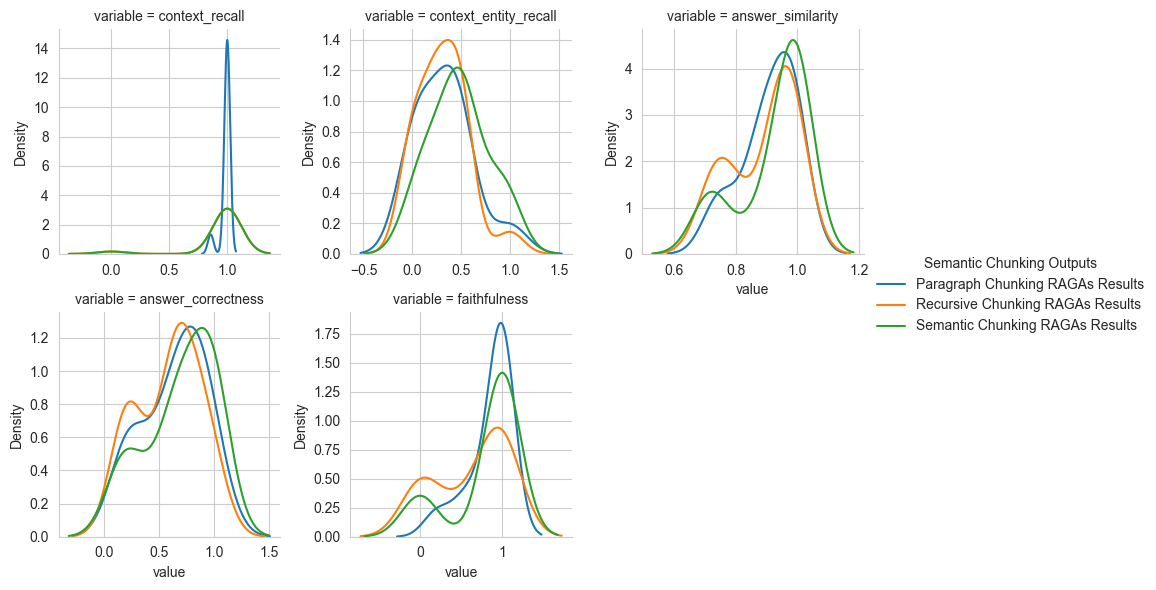

In [36]:
# Add a column to identify the source data frame
paragraph_ragas['source'] = 'Paragraph Chunking RAGAs Results'
recursive_ragas['source'] = 'Recursive Chunking RAGAs Results'
semantic_ragas['source'] = 'Semantic Chunking RAGAs Results'

df_list = [paragraph_ragas[['source','context_recall', 'context_entity_recall', 'answer_similarity', 'answer_correctness', 'faithfulness']],
    recursive_ragas[['source','context_recall', 'context_entity_recall', 'answer_similarity', 'answer_correctness', 'faithfulness']],
    semantic_ragas[['source','context_recall', 'context_entity_recall', 'answer_similarity', 'answer_correctness', 'faithfulness']]]

df_combined = pd.concat(df_list)

# Melt the data frame to long format
df_melted = pd.melt(df_combined, id_vars='source', var_name='variable', value_name='value')

# Create a FacetGrid
g = sns.FacetGrid(df_melted, col="variable", col_wrap=3, sharex=False, sharey=False, hue="source")
g = g.map(sns.kdeplot, "value", common_norm=False)

# Add legend with titles from the 'source' column
g.add_legend(title='Semantic Chunking Outputs')


############################################

#### MSMarco QA Data
--- Ran out of time after one month of project implementation in the fellowship.
- Sad attempt to use our own data. There might be better support [here.](https://docs.ragas.io/en/latest/howtos/customisations/bring-your-own-llm-or-embs.html)

In [68]:
print(df['question'][0])

nyu tuition cost


In [80]:
from tqdm import tqdm
from datasets import load_dataset, Dataset


In [ ]:
#build the semantic dataset

## implement the different chunking
## create semantic chunk dataset for testing
df_semantic = df
answers = []
# for chunk in semantic_chunks:
#     answers.append(semantic_rag_chain.invoke(df['question'][0]))
# print("Answers: ", answers)

#try doing this instead
for chunk in semantic_chunks:
    for q in tqdm(df['question']):
        print("q", q)
        answers.append(semantic_rag_chain.invoke(q))
        # print(answers)
print("Answers: ", answers)


df_semantic['answer'] = answers
df_semantic["contexts"] = semantic_chunks
# Ensure "contexts" is a list of lists of strings
df_semantic["contexts"] = df_semantic["contexts"].apply(lambda x: list(map(str, x)))
print(df_semantic)


MSMarco_QA_Docs_semantic = (Dataset.from_pandas(df_semantic, features = features))
print("MSMarco_QA_Docs_semantic", type(MSMarco_QA_Docs_semantic))


In [ ]:
print(df_semantic['answer'].head())

In [ ]:
result = evaluate(
    dataset = MSMarco_QA_Docs_semantic, 
    metrics= metrics,
    llm = llm,
    embeddings = embed_model,
    raise_exceptions=False,
    )
print(result)
df_semantic = result.to_pandas()
df_semantic.to_pickle('./ragas_result_semantic.pkl')
print(df_semantic.head())


In [ ]:
### create naive chunks dataset for testing
df_naive = df
answers = []
for chunk in naive_chunks:
    for q in df['question']:
        answers.append(naive_rag_chain.invoke(q))
print("Answers: ", answers)

df_naive['answer'] = answers
df_naive['contexts'] = naive_chunks
# Ensure "contexts" is a list of lists of strings
df_naive["contexts"] = df_naive["contexts"].apply(lambda x: list(map(str, x)))
print(df_naive)


MSMarco_QA_Docs_naive = (Dataset.from_pandas(df_naive, features = features))
print("MSMarco_QA_Docs_naive", type(MSMarco_QA_Docs_naive))

In [ ]:
result_naive = evaluate(
    dataset = MSMarco_QA_Docs_naive, 
    metrics= metrics,
    llm = llm,
    embeddings = embed_model,
    raise_exceptions=False,
    )
print(result_naive)
df_naive = result_naive.to_pandas()
df_naive.to_pickle("./ragas_result_naive.pkl")
print(df_naive.head())

In [ ]:
######
### create paragraph chunk dataset for testing
df_parag = df
answers = []
for chunk in paragraph_chunks:
    answers.append(paragraph_rag_chain.invoke(df['question'][0]))
print("Answers: ", answers)

df_parag['answer'] = answers
print(df_parag)

# Ensure "contexts" is a list of lists of strings
df_parag["contexts"] = paragraph_chunks
df_parag["contexts"] = df_parag["contexts"].apply(lambda x: list(map(str, x)))


MSMarco_QA_Docs_parag = (Dataset.from_pandas(df_parag, features = features))
print("MSMarco_QA_Docs_paragraph", type(MSMarco_QA_Docs_parag))


result_paragraph = evaluate(
    dataset = MSMarco_QA_Docs_parag, 
    metrics= metrics,
    llm = llm,
    embeddings = embed_model,
    raise_exceptions=False,
    )
print(result_paragraph)
df_paragraph = result_paragraph.to_pandas()
df_paragraph.to_pickle("./ragas_result_paragraph.pkl")
print(df_paragraph.head())